# Mini Project  1
### Course: IT0CH95 -3004 Data Science

-------
**Submitted By:**
**MD Hasibul Haque Zahid (2302302)**

**Install & Import all the Necessary Libraries**

In [1]:
# Install required libraries
!pip install scrapy pandas matplotlib seaborn
!pip install beautifulsoup4
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from IPython.core.display import HTML, display  # To display HTML tables with images
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from IPython.core.display import display, HTML


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 5.3 MB/s eta 0:00:00


**Used BeautfulSoup for Scraping**

In [2]:
# Function to scrape individual recipe pages using BeautifulSoup
def scrape_recipe_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract the recipe name
    try:
        name = soup.find('h1').text.strip()
    except AttributeError:
        name = 'N/A'

    # Extract the image URL (Existing logic)
    try:
        figure = soup.find('figure', class_='wp-block-image')
        image = figure.find('img')['src']
    except (TypeError, AttributeError):
        image = 'N/A'

    # Extract the image URL based on the new HTML class you shared ('wp-block-image')
    try:
        image_alt = soup.find('img', class_='wp-block-image')['src']  # New logic
        if image == 'N/A':  # Only overwrite if the original method fails
            image = image_alt if image_alt else 'N/A'
    except (TypeError, AttributeError):
        pass  # Retain original image value if this fails

    # Extract the calories
    try:
        nutrition_facts = soup.find_all('span')
        cal = "N/A"
        for fact in nutrition_facts:
            if "Calories" in fact.text:
                cal = fact.text.replace("Calories:", "").strip()
                break
    except AttributeError:
        cal = 'N/A'

    # Extract the recipe description (summary)
    try:
        description = soup.find('div', class_='entry-content').find('p').text.strip()
    except AttributeError:
        description = 'N/A'

    # Extract recipe keys (Existing logic)
    try:
        keys = soup.find('ul', class_='cat-icons post-icons').find_all('li')
        recipe_key = ' '.join([key.text.strip() for key in keys])
    except AttributeError:
        recipe_key = 'N/A'

    # Extract recipe keys based on the new class ('recipe-key') from your screenshot
    try:
        recipe_key_alt = ' '.join([key.text.strip() for key in soup.find_all('span', class_='recipe-key')])
        if recipe_key == 'N/A':  # Only overwrite if the original method fails
            recipe_key = recipe_key_alt if recipe_key_alt else 'N/A'
    except AttributeError:
        pass  # Retain original recipe key value if this fails

    # Extract WW Points
    try:
        points = soup.find('span', class_='recipe-meta-value recipe-ww-pp icon').text.strip()
    except AttributeError:
        points = 'N/A'

    # Return the scraped data as a dictionary
    return {
        'Name of the food': name,
        'image': image,  # Correctly storing the image URL under the 'image' key
        'calories': cal,
        'Personal Points': points,
        'summary': description,
        'The recipe Key': recipe_key  # Adjusted to reflect the class used for the recipe key
    }

# Function to scrape multiple pages
def scrape_pages(total_pages):
    base_url = "https://www.skinnytaste.com/recipe-index/"
    recipe_list = []

    for page in range(1, total_pages + 1):
        url = base_url + f"?_paged={page}"  # Dynamically set the page number
        print(f"Scraping page {page}: {url}")  # For debugging, to see if pages are incrementing correctly
        response = requests.get(url)

        if response.status_code != 200:
            print(f"Failed to load page {page}, skipping.")
            continue

        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')
        recipes = soup.find_all('article', class_='post')  # Find all recipe articles

        for recipe in recipes:
            # Find the link to the recipe page
            try:
                recipe_url = recipe.find('a')['href']
                recipe_data = scrape_recipe_page(recipe_url)  # Scrape the individual recipe page

                # Only add the recipe if none of its values are 'N/A'
                if all(value != 'N/A' for value in recipe_data.values()):
                    recipe_list.append(recipe_data)  # Append the scraped data to the list
            except (TypeError, AttributeError):
                continue

        print(f"Page {page} scraped successfully.")
        time.sleep(1)  # Be polite with a slight delay to avoid overloading the server

    return recipe_list

# Function to render the scraped data as an HTML table with images
def display_recipes_with_images(df):
    # Correctly refer to the 'image' column to render the actual image
    html = df.to_html(escape=False, formatters=dict(image=lambda x: f'<img src="{x}" width="200"/>'))
    display(HTML(html))

# Scrape the first 50 pages (you can adjust the number of pages)
recipes = scrape_pages(50)

# Filter only valid recipes and display images
if recipes:
    # Convert the data into a DataFrame
    df = pd.DataFrame(recipes)

    # Print the number of items found
    print(f"\nTotal items scraped: {len(df)}\n")

    # Display the data with actual images
    display_recipes_with_images(df)

    # Save the data to a CSV file for future use
    df.to_csv('skinnytaste_recipes.csv', index=False)
else:
    print("No recipes found with all required values.")


Scraping page 1: https://www.skinnytaste.com/recipe-index/?_paged=1
Page 1 scraped successfully.
Scraping page 2: https://www.skinnytaste.com/recipe-index/?_paged=2
Page 2 scraped successfully.
Scraping page 3: https://www.skinnytaste.com/recipe-index/?_paged=3
Page 3 scraped successfully.
Scraping page 4: https://www.skinnytaste.com/recipe-index/?_paged=4
Page 4 scraped successfully.
Scraping page 5: https://www.skinnytaste.com/recipe-index/?_paged=5
Page 5 scraped successfully.
Scraping page 6: https://www.skinnytaste.com/recipe-index/?_paged=6
Page 6 scraped successfully.
Scraping page 7: https://www.skinnytaste.com/recipe-index/?_paged=7
Page 7 scraped successfully.
Scraping page 8: https://www.skinnytaste.com/recipe-index/?_paged=8
Page 8 scraped successfully.
Scraping page 9: https://www.skinnytaste.com/recipe-index/?_paged=9
Page 9 scraped successfully.
Scraping page 10: https://www.skinnytaste.com/recipe-index/?_paged=10
Page 10 scraped successfully.
Scraping page 11: https://w

,Name of the food,image,calories,Personal Points,summary,The recipe Key
0,Breakfast Burritos,,261 kcal,5,"These freezer breakfast burritos are stuffed with scrambled eggs, scallions, bell pepper, bacon, and cheese, making them a delicious, protein-packed way to start the day! Freeze them for meal prep so you can have them ready all week long.",AF FM HF KF MP Q
1,Crustless Pumpkin Pie,,124.5 kcal,2,"Skip the crust and make this easy gluten-free, dairy-free crustless pumpkin pie this fall for a cozy night when you crave a pumpkin treat or as a healthier alternative for Thanksgiving.",DF GF HF V
2,Red Curry Salmon,,349 kcal,6,"Thai-inspired Red Curry Salmon is simmered in an incredibly tasty coconut red curry sauce with bell peppers, garlic and onions.",DF GF HP
3,Apple Butter,,34 kcal,1,"This easy apple butter recipe simmers on the stove, made with apples, cinnamon, nutmeg, and allspice, it smells and tastes like fall!",DF GF KF V
4,Roasted Delicata Squash,,177 kcal,4,"Roasted Delicata Squash with toasted almonds, sweetened with maple syrup and seasoned with sage and paprika, makes a perfect fall side dish.",DF GF V
5,Apple Bread,,124 kcal,4,"Moist cinnamon apple bread recipe made with applesauce, small chunks of fresh apples and walnuts in every bite. It’s so moist and delicious, you won’t believe it’s light!",V
6,Autumn Salad with Pears and Gorgonzola,,175 kcal,5,"I love a good salad with lots of texture and flavors, and this Autumn Salad nails it. Sweet pears, honey Dijon dressing, crunchy pecans, and creamy gorgonzola cheese create a delicious fall dish that’s hard to resist.",GF LC Q V
7,Sesame Chicken,,513 kcal,9,"This lighter Sesame Chicken recipe features chicken breast bites in a sweet, savory, tangy, and slightly spicy sauce topped with sesame seeds and green onions.",DF FM GF HP
8,Bacon in the Oven,,60 kcal,2,"Whether you’re a fan of tender, crisp, or extra crispy bacon, this simple method of cooking bacon in the oven is easy. There’s no stovetop mess, and it frees up your stove for cooking other breakfast items!",DF GF HP KF LC Q W
9,Pumpkin Spice Latte,,115 kcal,7,"Embrace all the cozy fall vibes with a homemade Pumpkin Spice Latte! This easy recipe tastes just like the original, but for a fraction of the cost.",DF GF V


**EDA and Visualisation**

Index(['Name of the food', 'image', 'calories', 'Personal Points', 'summary',
       'The recipe Key'],
      dtype='object')


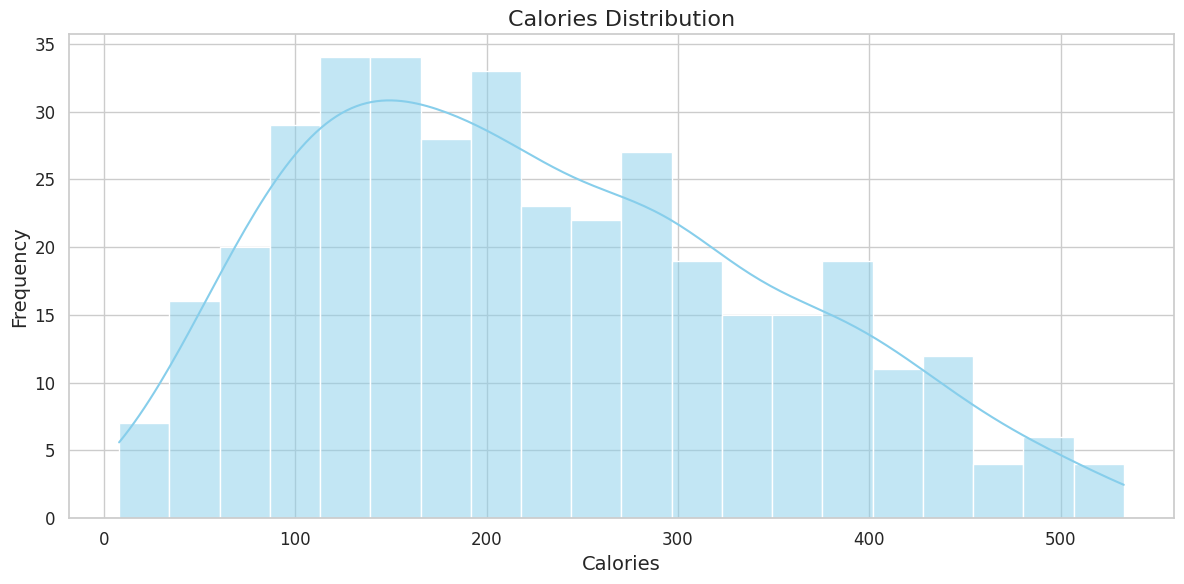

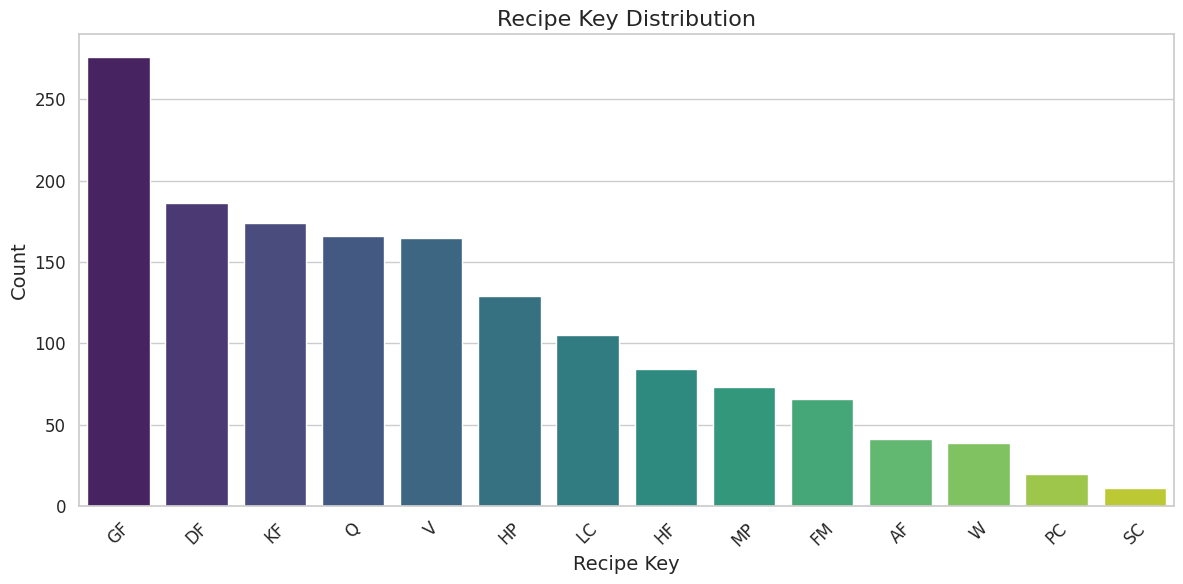

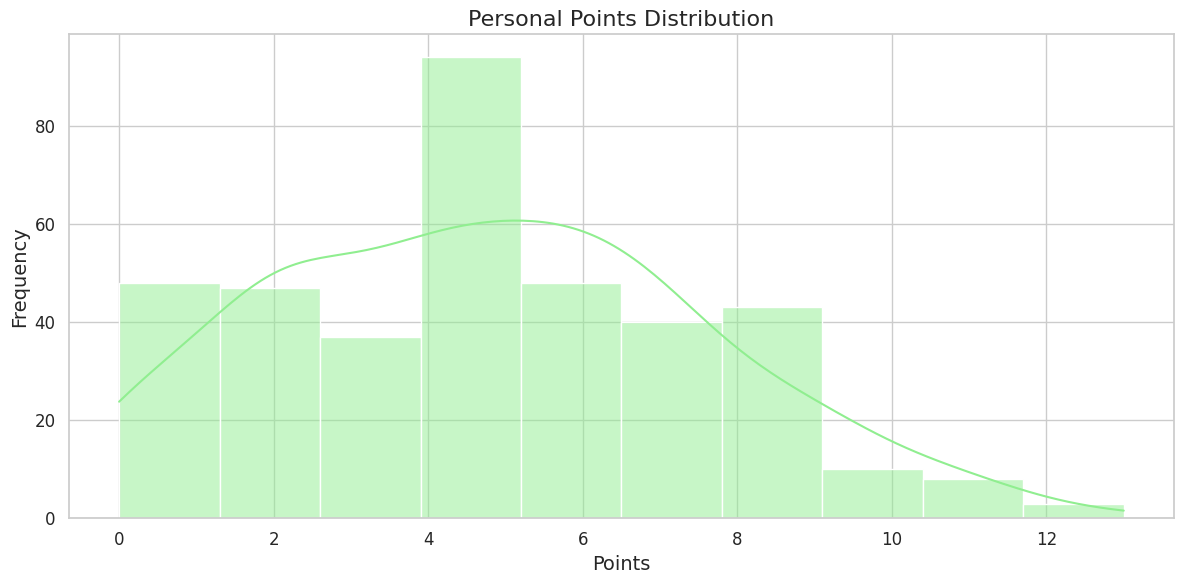

In [3]:
# Set a general theme for Seaborn to make plots more visually appealing
sns.set_theme(style="whitegrid")

# Function to clean the 'calories' and 'Personal Points' columns
def clean_data(df):
    # Remove non-numeric characters from 'calories' column and convert to float
    df['calories'] = df['calories'].apply(lambda x: float(re.sub(r'[^\d.]', '', str(x))) if x != 'N/A' else None)

    # Convert 'Personal Points' column to float
    df['Personal Points'] = df['Personal Points'].apply(lambda x: float(x) if x != 'N/A' else None)

    return df

# Function to plot calories distribution with better design

def plot_calories_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.histplot(df['calories'].dropna(), bins=20, kde=True, color="skyblue")
    plt.title('Calories Distribution', fontsize=16)
    plt.xlabel('Calories', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()  # Adjusts plot to make room for labels
    plt.show()

# Function to plot recipe key distribution with better design
def plot_recipe_key_distribution(df):
    # Fix column name issue by checking for the correct column
    recipe_key_column = df.columns[df.columns.str.contains('recipe', case=False, regex=True)].tolist()

    if not recipe_key_column:
        print("Recipe Key column not found.")
        return

    recipe_key_column = recipe_key_column[0]  # Take the first matching column

    plt.figure(figsize=(12, 6))
    recipe_keys = df[recipe_key_column].dropna().str.split(expand=True).stack().value_counts()
    sns.barplot(x=recipe_keys.index, y=recipe_keys.values, hue=recipe_keys.index, palette="viridis", dodge=False)
    plt.legend([],[], frameon=False)  # Hide the redundant legend
    plt.title('Recipe Key Distribution', fontsize=16)
    plt.xlabel('Recipe Key', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)  # Rotate x-ticks for better readability
    plt.yticks(fontsize=12)
    plt.tight_layout()  # Adjusts plot to make room for labels
    plt.show()

# Function to plot points distribution with better design
def plot_points_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.histplot(df['Personal Points'].astype(float).dropna(), bins=10, kde=True, color="lightgreen")
    plt.title('Personal Points Distribution', fontsize=16)
    plt.xlabel('Points', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Uncomment this line to load your scraped data
df = pd.read_csv('skinnytaste_recipes.csv')  # Load your data here

# Print column names to verify if they are correct
print(df.columns)

# Clean the data first
df = clean_data(df)

# Call the enhanced plotting functions
plot_calories_distribution(df)
plot_recipe_key_distribution(df)
plot_points_distribution(df)


**EDA and Visualisation**


Index(['Name of the food', 'image', 'calories', 'Personal Points', 'summary',
       'The recipe Key'],
      dtype='object')


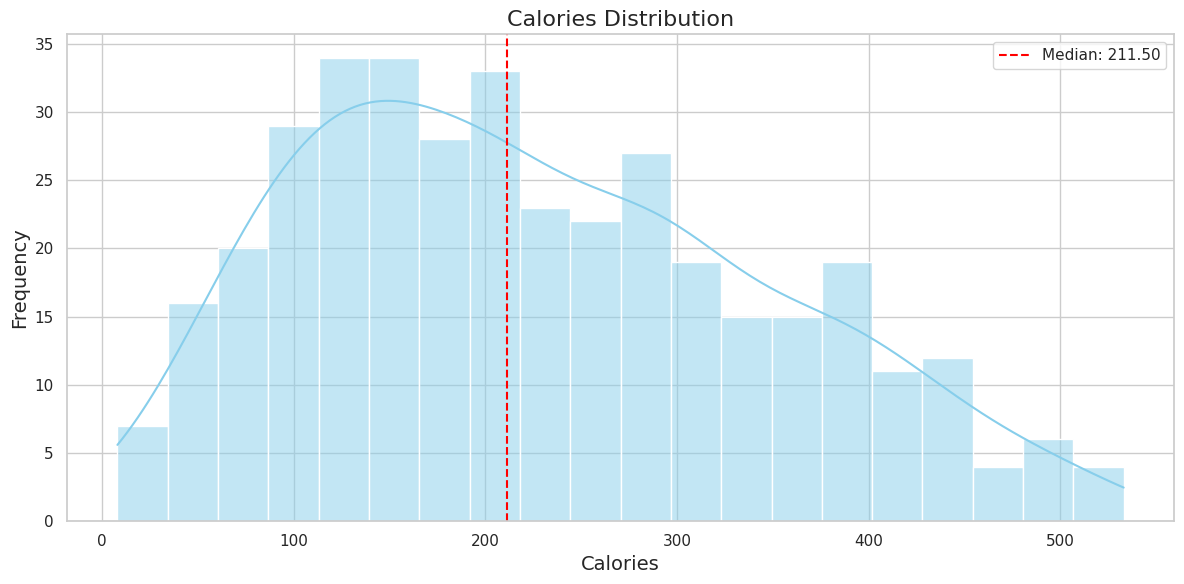

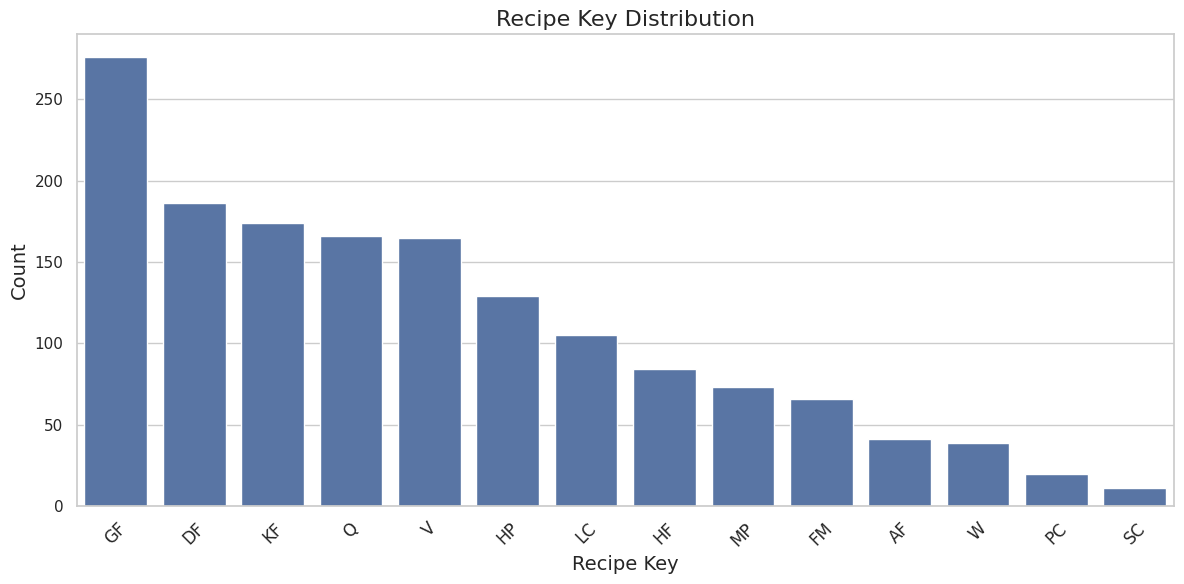

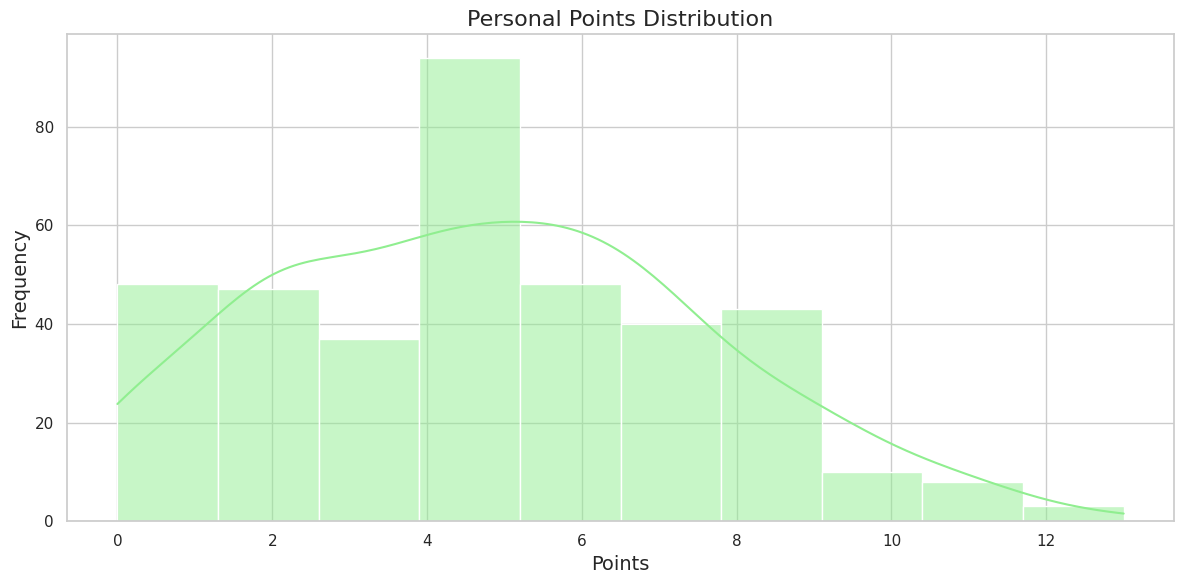

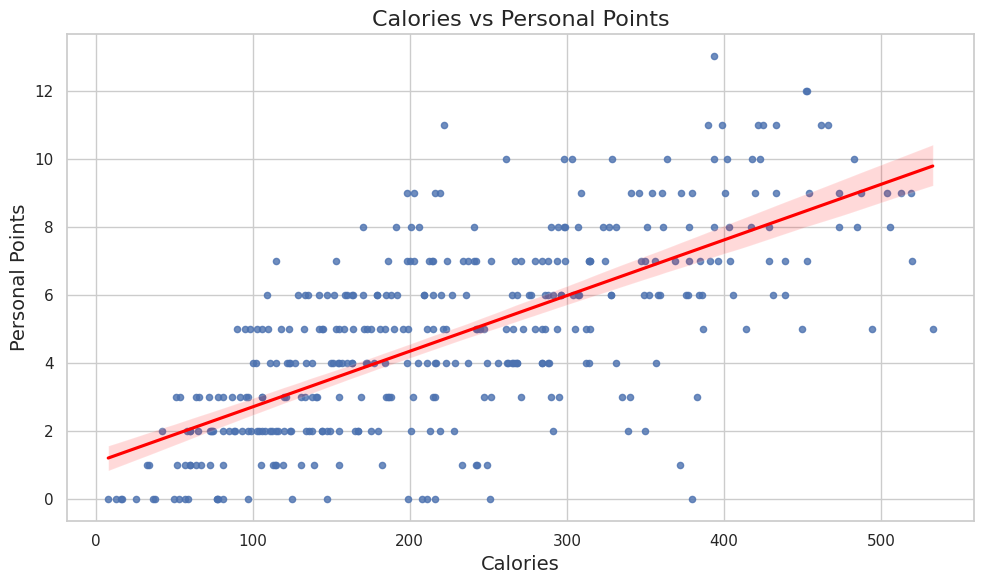

<ipython-input-4-47a5c1687c25>:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Recipe Key', y='calories', data=df_expanded, palette="Set2")


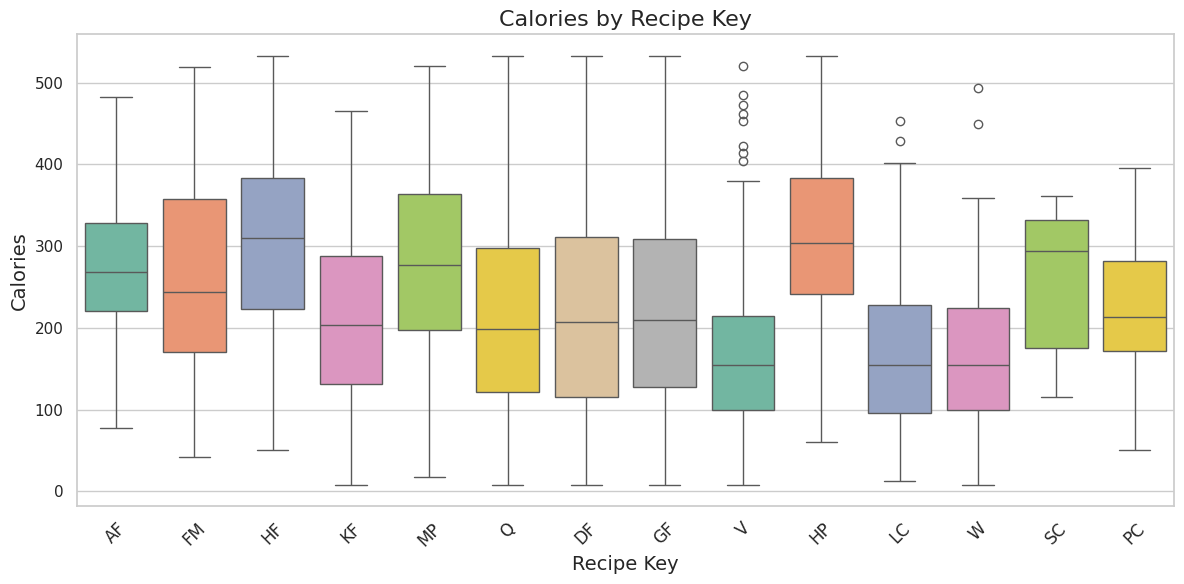

In [4]:


# Set a general theme for Seaborn to make plots more visually appealing
sns.set_theme(style="whitegrid")

# Function to clean the 'calories' and 'Personal Points' columns
def clean_data(df):
    # Remove non-numeric characters from 'calories' column and convert to float
    df['calories'] = df['calories'].apply(lambda x: float(re.sub(r'[^\d.]', '', str(x))) if x != 'N/A' else None)

    # Convert 'Personal Points' column to float
    df['Personal Points'] = df['Personal Points'].apply(lambda x: float(x) if x != 'N/A' else None)

    return df

# Function to plot calories distribution with better design and annotation
def plot_calories_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.histplot(df['calories'].dropna(), bins=20, kde=True, color="skyblue")
    plt.title('Calories Distribution', fontsize=16)
    plt.xlabel('Calories', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Annotating the median
    median = df['calories'].median()
    plt.axvline(median, color='red', linestyle='--', label=f'Median: {median:.2f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot recipe key distribution (Bar Plot) with dynamic column reference
def plot_recipe_key_distribution(df):
    # Dynamically find the correct column for recipe keys
    recipe_key_col = [col for col in df.columns if 'recipe key' in col.lower()]

    if not recipe_key_col:
        print("No 'recipe key' column found.")
        return

    recipe_key_col = recipe_key_col[0]  # Use the first match
    plt.figure(figsize=(12, 6))
    recipe_keys = df[recipe_key_col].dropna().str.split(expand=True).stack().value_counts()

    sns.barplot(x=recipe_keys.index, y=recipe_keys.values)

    plt.title('Recipe Key Distribution', fontsize=16)
    plt.xlabel('Recipe Key', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.show()

# Function to plot points distribution with KDE curve
def plot_points_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.histplot(df['Personal Points'].astype(float).dropna(), bins=10, kde=True, color="lightgreen")
    plt.title('Personal Points Distribution', fontsize=16)
    plt.xlabel('Points', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.tight_layout()
    plt.show()

# Function to plot the correlation between Calories and Personal Points (Scatter Plot)
def plot_calories_vs_points(df):
    plt.figure(figsize=(10, 6))
    sns.regplot(x='calories', y='Personal Points', data=df.dropna(subset=['calories', 'Personal Points']),
                scatter_kws={'s':20}, line_kws={"color":"red"})
    plt.title('Calories vs Personal Points', fontsize=16)
    plt.xlabel('Calories', fontsize=14)
    plt.ylabel('Personal Points', fontsize=14)
    plt.tight_layout()
    plt.show()

# Function to plot Calories by Recipe Key (Box Plot) with dynamic column reference
def plot_recipe_key_vs_calories(df):
    # Dynamically find the correct column for recipe keys
    recipe_key_col = [col for col in df.columns if 'recipe key' in col.lower()]

    if not recipe_key_col:
        print("No 'recipe key' column found.")
        return

    recipe_key_col = recipe_key_col[0]  # Use the first match
    plt.figure(figsize=(12, 6))
    recipe_key_expanded = df[recipe_key_col].str.split(expand=True).stack().reset_index(level=1, drop=True)
    df_expanded = df[['calories']].join(recipe_key_expanded.rename('Recipe Key')).dropna()

    sns.boxplot(x='Recipe Key', y='calories', data=df_expanded, palette="Set2")

    plt.title('Calories by Recipe Key', fontsize=16)
    plt.xlabel('Recipe Key', fontsize=14)
    plt.ylabel('Calories', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.show()

# Uncomment this line to load your scraped data
df = pd.read_csv('skinnytaste_recipes.csv')

# Print column names to check for correct column references
print(df.columns)

# Step 3 EDA - Clean the data and plot the required visualizations
df = clean_data(df)

# 1. Calories Distribution with Annotation (Median)
plot_calories_distribution(df)

# 2. Recipe Key Distribution (Bar Plot)
plot_recipe_key_distribution(df)

# 3. Personal Points Distribution with KDE Curve
plot_points_distribution(df)

# 4. Calories vs Personal Points (Scatter Plot)
plot_calories_vs_points(df)

# 5. Calories by Recipe Key (Box Plot)
plot_recipe_key_vs_calories(df)


**User interaction**

In [5]:
import pandas as pd
from IPython.core.display import HTML, display
import re

# Function to clean the 'calories' and 'Personal Points' columns
def clean_data(df):
    # Remove non-numeric characters from 'calories' column and convert to float
    df['calories'] = df['calories'].apply(lambda x: float(re.sub(r'[^\d.]', '', str(x))) if x != 'N/A' else None)

    # Convert 'Personal Points' column to float
    df['Personal Points'] = df['Personal Points'].apply(lambda x: float(x) if x != 'N/A' else None)

    return df

# Function to filter based on calorie and points range
def filter_foods_by_calories_and_points(df, calorie_range, points_range):
    filtered_df = df[
        (df['calories'].between(calorie_range[0], calorie_range[1])) &
        (df['Personal Points'].between(points_range[0], points_range[1]))
    ]
    return filtered_df.sort_values(by='calories')

# Function to render the filtered results as an HTML table with images
def display_filtered_results(filtered_df):
    if filtered_df.empty:
        print("No foods found in the specified range.")
    else:
        # Limit to first 10 results and display only 'Name of the food', 'image', 'calories', and 'summary'
        filtered_df = filtered_df[['Name of the food', 'image', 'calories', 'summary']].head(10)

        # Display the table with images embedded
        html = filtered_df.to_html(escape=False, formatters={
            'image': lambda x: f'<img src="{x}" width="150"/>',
            'calories': lambda x: f'{x:.0f} kcal' if pd.notnull(x) else 'N/A'  # Formatting calories
        })
        display(HTML(html))

# Function to validate the user's input and return it as a tuple
def get_user_input(prompt):
    while True:
        try:
            # Take user input and split it into two values
            user_input = input(prompt).split()
            if len(user_input) != 2:
                raise ValueError("Please enter exactly two numbers separated by a space.")

            # Convert the inputs to integers
            min_val, max_val = map(int, user_input)

            # Validate that min is less than max
            if min_val >= max_val:
                raise ValueError("The first value must be smaller than the second value.")

            return min_val, max_val

        except ValueError as e:
            # Print an error message and prompt the user again
            print(f"Invalid input: {e}. Please try again.")

# User interaction
def user_interaction(df):
    # Clean the data first
    df = clean_data(df)

    # Get calorie range input from user with validation
    min_cal, max_cal = get_user_input("Enter your calorie range (e.g., 100 300): ")

    # Get points range input from user with validation
    min_points, max_points = get_user_input("Enter your points range (e.g., 2 10): ")

    # Filter the data based on the user's input
    filtered_df = filter_foods_by_calories_and_points(df, (min_cal, max_cal), (min_points, max_points))

    # Count the number of items found
    item_count = len(filtered_df)

    # Display the count to the user
    print(f"Total food items found: {item_count}")

    # Display the filtered results in table format
    display_filtered_results(filtered_df)

# Run the user interaction
user_interaction(df)


Enter your calorie range (e.g., 100 300): 100 300
Enter your points range (e.g., 2 10): 2 10
Total food items found: 200


,Name of the food,image,calories,summary
368,Caprese Salad,,100 kcal,"Caprese Salad or Insalata Caprese is a simple summer salad with fresh mozzarella, thick slices of juicy tomatoes, basil and a splash of balsamic vinegar. Serve it as an appetizer, side dish, or just make it a meal!"
224,Grilled Pineapple,,102 kcal,"This quick and easy Grilled Pineapple with honey, lime juice, and cinnamon is the perfect dessert for summer dinners or backyard parties!"
194,Cauliflower Rice,,103 kcal,"Here’s a step-by-step recipe for making easy, low-carb cauliflower rice from scratch in the skillet or roasted in the oven. It’s delicious in bowls, arancini, stir fries, meal prep, and more."
177,Pumpkin Bread Recipe,,103 kcal,"Warm your kitchen with the aroma of pumpkin spice by baking this healthy pumpkin bread, ideal for cool, cozy fall days."
179,Pumpkin Baked Oatmeal Cups,,104 kcal,"Made with pumpkin puree, oats, pumpkin pie spice, and Greek yogurt, these Pumpkin Baked Oatmeal Cups are an easy, creamy breakfast full of fall flavor. They’re perfect to make in advance for breakfast on-the-go!"
83,Baked Honey-Mustard Ham,,106 kcal,"This easy, 4-ingredient Honey-Mustard Ham recipe is made with honey, Dijon mustard, and a touch of brown sugar on a baked spiral ham."
274,Roasted Carrots,,106 kcal,"These easy Roasted Carrots with bake in the oven with garlic and fresh herbs like thyme, and parsley. They’re a healthy side dish that goes well with any protein, like lamb, roasted chicken or turkey."
22,Coconut Popsicles,,106 kcal,"These homemade coconut popsicles are rich, creamy, and super simple to make! They’re the perfect summertime refresher."
27,Grilled Eggplant with Feta,,106 kcal,"If you need an easy side dish this summer, this grilled eggplant with feta cheese is great with anything you’re grilling."
176,Coconut Curry Butternut Squash Soup,,108 kcal,"This Butternut Squash Soup is made with coconut milk, curry, and Indian spices which perfectly compliment the flavor of the butternut squash. It’s easy to make and leftovers store well!"
